<a href="https://colab.research.google.com/github/lautitorraca/7506R-2C2023-GRUPO24/blob/main/TP1/7506R_TP1_GRUPO24_CHP3_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico 1: Reservas de Hotel

## 𝔾𝕣𝕦𝕡𝕠 𝟚𝟜 (Merequetengue👍)

      ➢ Torraca Lautaro - 108813
      ➢ Negrotti Gianluca - 108184
      ➢ Marco Tosi - 107237

#TODO: ORGANIZAR EL CODIGO

### » Imports

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from google.colab import files


from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# » Lectura de los archivos

In [49]:
url_train = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/hotels_train.csv'
url_test = 'https://raw.githubusercontent.com/lautitorraca/7506R-2C2023-GRUPO24/main/TP1/DataSets/df_base_limpio.csv'

ds_train_base = pd.read_csv(url_train)
ds_test_base = pd.read_csv(url_test)

ds_test = ds_test_base.copy()
df_test = pd.DataFrame(ds_test_base)

ds_train = ds_train_base.copy()
df_train = pd.DataFrame(ds_train_base)

### » Entramiento y prediccion con el primer modelo de arbol planteado. (Modelo 1)

Procedemos a buscar los paises que se encuentran en ambos DataSets y hacemos que coincidan los de train con los de test.

In [50]:
df_train['room_type_match'] = df_train['assigned_room_type'] == df_train['reserved_room_type']
df_test['room_type_match'] = df_test['assigned_room_type'] == df_test['reserved_room_type']
df_test
df_train['days_in_waiting_list'] = df_train['days_in_waiting_list'] >= 0

df_train['cancel_to_noncancel_ratio'] = df_train['previous_cancellations'] / (1 + df_train['previous_bookings_not_canceled'])
df_test['cancel_to_noncancel_ratio'] = df_test['previous_cancellations'] / (1 + df_test['previous_bookings_not_canceled'])

df_train['lead_time_category'] = pd.cut(df_train['lead_time'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)
df_test['lead_time_category'] = pd.cut(df_test['lead_time'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)

df_train['days_in_waiting_list_category'] = pd.cut(df_train['days_in_waiting_list'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)
df_test['days_in_waiting_list_category'] = pd.cut(df_test['days_in_waiting_list'], bins=[0, 10, 50, 100, 500, 10000], labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'], right=False)

In [51]:
columnas_faltantes_en_train = set(df_test.columns) - set(df_train.columns)
columnas_faltantes_en_test = set(df_train.columns)- set(df_test.columns)
print('Columnas faltantes es train:', columnas_faltantes_en_train)
print('Columnas faltantes es test:', columnas_faltantes_en_test)

print('Train:', df_train.shape)
print('Test:', df_test.shape)

Columnas faltantes es train: {'Unnamed: 0', 'reservation_status_date', 'z_adr', 'z_total_of_special_requests', 'mahalanobis', 'z_stays_in_weekend_nights'}
Columnas faltantes es test: {'is_canceled'}
Train: (61913, 35)
Test: (26535, 40)


In [52]:
df_train.dropna(subset=['children'], inplace=True)

df_train.dropna(subset=['agent'], inplace=True)

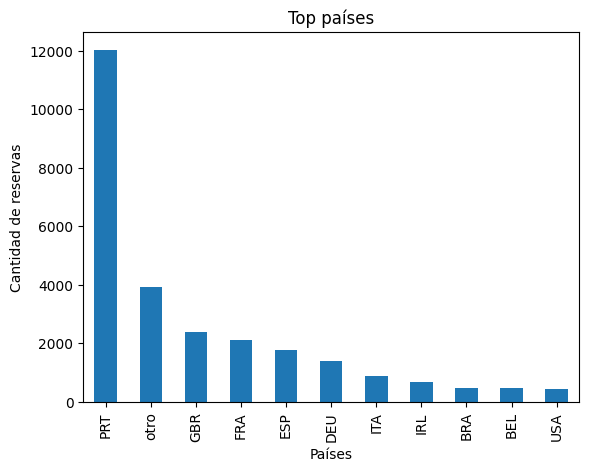

In [53]:
country_counts_train = df_train['country'].value_counts()
country_counts_test = df_test['country'].value_counts()

# Selecciona los 10 países más relevantes
top_10_countries_train = country_counts_train.head(10).index.tolist()
top_10_countries_test = country_counts_test.head(10).index.tolist()

# Reemplaza los países que no están en los 10 más relevantes con "otro"
df_train['country'] = df_train['country'].apply(lambda x: x if x in top_10_countries_train else 'otro')
df_test['country'] = df_test['country'].apply(lambda x: x if x in top_10_countries_test else 'otro')


In [54]:
market_segment_counts_train = df_train['market_segment'].value_counts()
market_segment_counts_test = df_test['market_segment'].value_counts()


top_3_ms_train = market_segment_counts_train.head(4).index.tolist()
top_3_ms_test = market_segment_counts_test.head(4).index.tolist()

df_train['market_segment'] = df_train['market_segment'].apply(lambda x: x if x in top_3_ms_train else 'otro')
df_test['market_segment'] = df_test['market_segment'].apply(lambda x: x if x in top_3_ms_test else 'otro')

In [55]:
ct_counts_train = df_train['customer_type'].value_counts()
ct_counts_test = df_test['customer_type'].value_counts()


top_ct_train = ct_counts_train.head(2).index.tolist()
top_ct_test = ct_counts_test.head(2).index.tolist()

df_train['customer_type'] = df_train['customer_type'].apply(lambda x: x if x in top_ct_train else 'otro')
df_test['customer_type'] = df_test['customer_type'].apply(lambda x: x if x in top_ct_test else 'otro')


In [56]:
columna_a_eliminar_test = 'reservation_status_date'

df_test.drop(columna_a_eliminar_test, axis='columns', inplace = True)
df_test.insert(1, 'is_canceled', " ")
df_test = pd.DataFrame(df_test)

In [57]:

features = ['lead_time_category','booking_changes','required_car_parking_spaces','total_of_special_requests','room_type_match','cancel_to_noncancel_ratio', 'is_repeated_guest',
             'previous_cancellations','country', 'market_segment', 'deposit_type', 'distribution_channel', 'stays_in_weekend_nights', 'adults','babies', 'days_in_waiting_list_category',
             'customer_type','is_canceled','id']


df_trabajo_train = df_train[features]
df_trabajo_test = df_test[features]




In [58]:
columns_to_dum= ['lead_time_category', 'country', 'market_segment', 'deposit_type', 'distribution_channel', 'days_in_waiting_list_category', 'customer_type']
df_trabajo_train_dum = pd.get_dummies(df_trabajo_train, columns = columns_to_dum)
df_trabajo_test_dum = pd.get_dummies(df_trabajo_test, columns = columns_to_dum)

- **Entrenamiento del arbol**

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from sklearn.metrics import accuracy_score

df_trabajo_x= df_trabajo_train_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo_train_dum['is_canceled'].copy()

x_train, x_test, y_train, y_test= train_test_split(df_trabajo_x,
                                                       df_trabajo_y,
                                                       test_size=0.30,
                                                       random_state=13)


In [60]:
def mostrar_metricas(y_test, y_pred):
    accuracy=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

In [61]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(19,20) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))

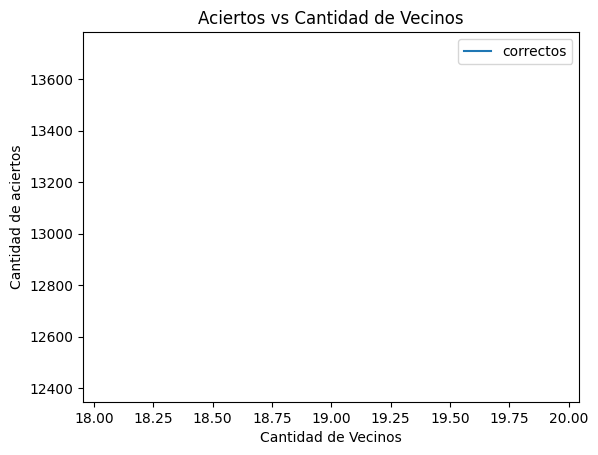

In [62]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos',
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()


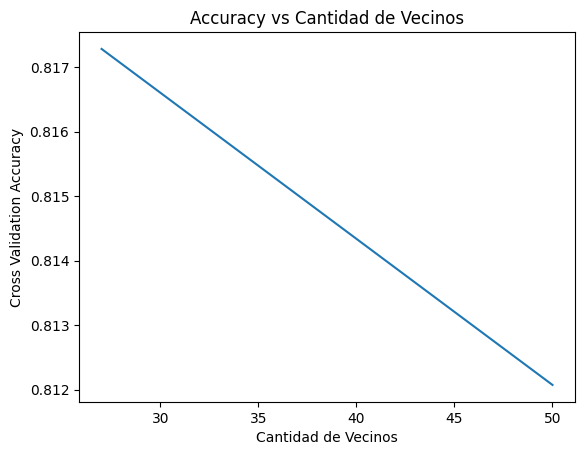

In [63]:
from sklearn.model_selection import cross_val_score

k_range=[27,50] #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train, cv=10,scoring='f1')
    #promedio las 10 métricas
    k_scores.append(scores.mean())
    #ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

In [64]:
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

#Métricas Válidas
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [ 'braycurtis','canberra','chebyshev','correlation',
        'cosine','dice','hamming','jaccard','kulsinski',
        'mahalanobis','matching','minkowski','rogerstanimoto',
        'russellrao','seuclidean','sokalmichener','sokalsneath',
        'sqeuclidean','yule','wminkowski','pdist'
    ],
)

#Ejemplo
for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'pdist']



In [65]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':[50],
              'weights':['distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute', 'auto'],
              'metric':['minkowski']
             }
# nca = NeighborhoodComponentsAnalysis(random_state=13)
# nca.fit(x_train, y_train)
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5)

rand.fit(x_train, y_train)

rand.cv_results_['mean_test_score']

array([0.81866637, 0.8193746 , 0.81906801, 0.81906801])

In [66]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 50, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
0.8193746023263051


In [67]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)

#Accuracy test
accuracy_score(y_test, y_pred)

0.8136607638674647

In [ ]:
tabla1 = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla1,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')


In [68]:
mostrar_metricas(y_test, y_pred)

Accuracy: 0.8136607638674647
Recall: 0.8381054640897161
Precision: 0.8085865561694291
f1 score: 0.8230814294083187


In [72]:

# df_trabajo_test_x = df_trabajo_test_dum.drop(['is_canceled', 'id'], axis='columns', inplace=False)
# ids1 = df_trabajo_test_dum['id'].copy()


# prediccion1 = best_knn.predict(df_trabajo_test_x)

# df_prediccion1 = pd.DataFrame({'id': ids1, 'is_canceled': prediccion1})

# df_prediccion1.to_csv('df_prediccion1.csv')
# files.download('df_prediccion1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>